# 0 - Instalation of modules

In [ ]:
#Run this cell to have the progress bar
!pip install tqdm
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [123]:
%reset

# 1 - Importing modules

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# 2 - Get all files needed

In [2]:
data_folder = "../../Dataset/Movie/"

In [3]:
rating = pd.read_csv(f"{data_folder}ratings.csv").drop(["timestamp"], axis=1)
movie = pd.read_csv(f"{data_folder}movies.csv")

data = pd.merge(movie, rating, on="movieId").drop(["genres", "movieId"], axis=1)
data.shape

(25000095, 3)

# 3 - Transforming data

In [4]:
#On garde les NB_FILM films les plus notés
NB_FILM = 500
keep_title = data["title"].value_counts().sort_values(ascending=False)[:NB_FILM].index
data_title = data[data["title"].isin(keep_title)]
data_title.shape

(10944751, 3)

In [5]:
#On garde les users qui ont données une note sur au moins THRESH_USER % des films
THRESH_USER = 0.40
keep_user = data_title["userId"].value_counts()/NB_FILM >= THRESH_USER
data_title_user = data_title[data_title["userId"].isin(keep_user[keep_user].index)]

In [6]:
#On fait notre pivot table
user_title_df = data_title_user.pivot_table(index="userId", columns="title", values="rating")
user_title_df.to_csv(f"{data_folder}test_for_users.csv")
user_title_df.shape

(10103, 500)

# 4 - Colaborative filtering

In [77]:
#Récupérer les données si elles sont en local
user_title_df = pd.read_csv(f"{data_folder}test_for_users.csv", index_col=0)
user_title_df.shape

(10103, 500)

In [78]:
#Standardisation des lignes pour supprimer les biais
def normalization_mean(row):
    return row - row.mean()

def normalization_min_max(row):
    return (row - row.mean())/(row.max() - row.min())

def normalization_std(row):
    return (row - row.mean())/row.std()  

## 4.1 - Users to users

In [79]:
for_users_data = {}
for_users_data["min_max"] = user_title_df.fillna(0).apply(normalization_min_max, axis=1)
for_users_data["mean"] = user_title_df.fillna(0).apply(normalization_mean, axis=1)
for_users_data["std"] = user_title_df.fillna(0).apply(normalization_std, axis=1)

In [80]:
#Création de la matrice de cosinus distance
all_users = user_title_df.index
similarity_users = {"Cosinus" : {}, "Pearson" : {}}

for method in for_users_data.keys():
    cos = cosine_similarity(for_users_data[method])
    similarity_users["Cosinus"][method] = pd.DataFrame(cos, index=all_users, columns=all_users)
    np.fill_diagonal(similarity_users["Cosinus"][method].values, 0)

    corr = np.corrcoef(for_users_data[method])
    similarity_users["Pearson"][method] = pd.DataFrame(corr, index=all_users, columns=all_users)
    np.fill_diagonal(similarity_users["Pearson"][method].values, 0)

del(cos)
del(corr)

In [81]:
#On devine la note en fonction des candidtats similaires
def guess_rate(user, title, distance, method, N):
    similar_mat = similarity_users[distance][method]
    all_similar_users = similar_mat.loc[user].sort_values(ascending=False).index
    user_title_mat = for_users_data[method]
    
    rate = 0
    weight = 0
    k = 0
    i = 0

    while (k < N):
        similar_user = all_similar_users[i]
        r = user_title_mat.loc[similar_user, title]

        if not (pd.isnull(r)):
            w = similar_mat.loc[similar_user, user]
            rate += w*r
            weight += w
            k += 1

        i += 1

    return rate/weight

In [82]:
def get_similar_movies_from_users(user_id, distance, method, N):
    all_rates = []
    keep_movies = []

    for movie in tqdm(user_title_df.columns):
        if (pd.isnull(user_title_df.loc[user_id, movie])):
            all_rates.append(guess_rate(user_id, movie, distance, method, N))
            keep_movies.append(movie)

    return pd.Series(all_rates, keep_movies).sort_values(ascending=False)

In [13]:
similar_movies = {"Cosinus" : {"min_max" : [], "mean" : [], "std" : []}, "Pearson" : {"min_max" : [], "mean" : [], "std" : []}}

for distance in similar_movies.keys():
    for method in similar_movies[distance].keys():
        similar_movies[distance][method] = get_similar_movies_from_users(12, distance, method, 10).index

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:03<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
cos_recommanded = pd.DataFrame.from_dict(similar_movies["Cosinus"])
corr_recommanded = pd.DataFrame.from_dict(similar_movies["Pearson"])
((cos_recommanded == corr_recommanded).all()).all()
#Aucune différence entre Cosinus et Pearson

True

In [15]:
(cos_recommanded["min_max"] == cos_recommanded["mean"]).all()       #100% pareil
np.mean(cos_recommanded["min_max"] == cos_recommanded["std"])*100   #39.91% pareil

39.91935483870967

In [16]:
k = 0
arg_diff = []
for movie in cos_recommanded["mean"].values:
    arg = np.where(cos_recommanded["std"] == movie)[0][0]
    if (arg != k):
        arg_diff.append(abs(k-arg))
    k += 1
np.mean(arg_diff)
#Il n'y a que 2/3 places de différences entre chaque films

2.4563758389261743

In [17]:
#On compare les deux méthodes
from time import time

NB_USER = 20
NB_MOVIE = 20
MAX = 100
STEP = 2

stats = {}

for N in tqdm([i*STEP for i in range(1, MAX)]):
    for distance in ["Cosinus", "Pearson"]:
        stats[distance] = {"min_max" : [], "mean" : [], "std" : []}

        for user_id in user_title_df.index[:NB_USER]:
            all_rated_movies = user_title_df.loc[user_id].dropna()[:NB_MOVIE]

            for movie in all_rated_movies.index:
                for method in ["min_max", "mean", "std"]:
                    start = time()
                    rate = guess_rate(user_id, movie, distance, method, N)
                    stats[distance][method].append(time() - start)

  0%|          | 0/99 [00:00<?, ?it/s]

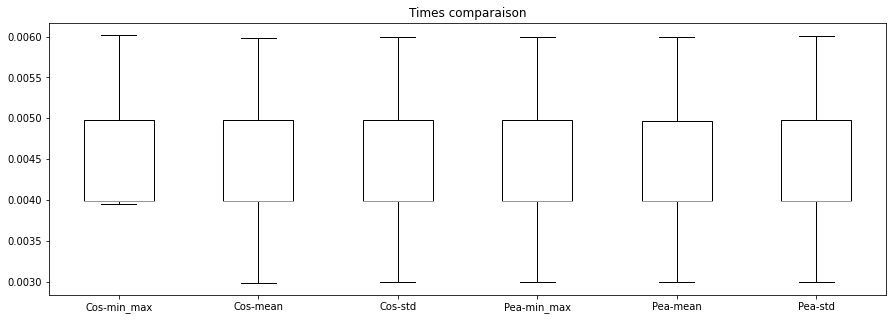

In [18]:
plt.figure(figsize=(15, 5))

plots = []
labels = []

for distance in stats.keys():
    for method in stats[distance].keys():
        plots.append(stats[distance][method])
        labels.append(f"{distance[:3]}-{method}")

plt.boxplot(plots, labels=labels, showfliers=False)
plt.title("Times comparaison")
plt.show()

## 4.2 - Movie to movie

In [83]:
for_movies_data = {}
for_movies_data["min_max"] = user_title_df.fillna(0).apply(normalization_min_max, axis=0)
for_movies_data["mean"] = user_title_df.fillna(0).apply(normalization_mean, axis=0)
for_movies_data["std"] = user_title_df.fillna(0).apply(normalization_std, axis=0)

In [84]:
#Création de la matrice de cosinus distance
all_movies = user_title_df.columns
similarity_movies = {"Cosinus" : {}, "Pearson" : {}}

for method in for_movies_data.keys():
    cos = cosine_similarity(for_movies_data[method].T)
    similarity_movies["Cosinus"][method] = pd.DataFrame(cos, index=all_movies, columns=all_movies)
    np.fill_diagonal(similarity_movies["Cosinus"][method].values, 0)

    corr = np.corrcoef(for_movies_data[method].T)
    similarity_movies["Pearson"][method] = pd.DataFrame(corr, index=all_movies, columns=all_movies)
    np.fill_diagonal(similarity_movies["Pearson"][method].values, 0)

del(cos)
del(corr)

In [85]:
def get_similar_movies_from_movies(user_id, distance, method):
    similar_movies = pd.DataFrame()

    movies_rates = user_title_df.loc[user_id].dropna()
    movies = movies_rates.index
    rates = movies_rates.values
    user = [(movies[i], rates[i]) for i in range(len(rates))]

    for movie, rate in tqdm(user):
        movie_list = (similarity_movies[distance][method].loc[:, movie]*(rate-2.5)).sort_values(ascending=False)
        similar_movies = similar_movies.append(movie_list)

    
    similar_movies = similar_movies.T.drop([movie for movie, rate in user], axis=0)
    return similar_movies.sum(axis=1).sort_values(ascending=False)

In [14]:
similar_movies = {"Cosinus" : {"min_max" : [], "mean" : [], "std" : []}, "Pearson" : {"min_max" : [], "mean" : [], "std" : []}}

for distance in similar_movies.keys():
    for method in similar_movies[distance].keys():
        similar_movies[distance][method] = get_similar_movies_from_movies(12, distance, method).index

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

In [16]:
cos_recommanded = pd.DataFrame.from_dict(similar_movies["Cosinus"])
corr_recommanded = pd.DataFrame.from_dict(similar_movies["Pearson"])
((cos_recommanded == corr_recommanded).all()).all()
#Aucune différence entre Cosinus et Pearson

True

In [20]:
(cos_recommanded["min_max"] == cos_recommanded["mean"]).all() 
(cos_recommanded["min_max"] == cos_recommanded["std"]).all()
#Aucune différence

True

## 4.3 - Mix

In [86]:
def recommanded_movies_2(user_id):
    distance = "Cosinus"
    method = "min_max"

    get_users = get_similar_movies_from_users(user_id, distance, method, 15)
    get_movies = get_similar_movies_from_movies(user_id, distance, method)
    get_users.name = "User Values"
    get_movies.name = "Movie Values"

    df = pd.merge(get_users, get_movies, left_index=True, right_index=True)
    df["Somme"] = df["User Values"] + df["Movie Values"]

    return df.sort_values("Somme", ascending=False)
        

In [87]:
def recommanded_movies(user_id):
    distance = "Cosinus"
    method = "min_max"
    
    get_users = get_similar_movies_from_users(user_id, distance, method, 15)
    get_movies = get_similar_movies_from_movies(user_id, distance, method)

    arg_movies = []
    for title in get_users.index:
        arg_movies.append(int(np.argwhere(get_movies.index == title)))

    recommanded = pd.DataFrame(index=get_users.index, columns=["Arg Users", "Arg Movies"], data=np.array([range(len(arg_movies)), arg_movies]).T)
    recommanded["Mean"] = recommanded.mean(axis=1)

    return recommanded.sort_values(by="Mean")

In [88]:
test1 = recommanded_movies_2(12)
test2 = recommanded_movies(12)

k = 0
arg_diff = []
for movie in test1.index:
    arg = np.where(test2.index == movie)[0][0]
    if (arg != k):
        arg_diff.append(abs(k-arg))
    k += 1
np.mean(arg_diff)
#Il y a que 23 places de différences, en moyenne, entre chaque films

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

23.382716049382715

In [91]:
test2

,Arg Users,Arg Movies,Mean
"Graduate, The (1967)",9,0,4.5
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),1,16,8.5
Quiz Show (1994),20,1,10.5
One Flew Over the Cuckoo's Nest (1975),8,18,13.0
Close Encounters of the Third Kind (1977),31,2,16.5
...,...,...,...
Edge of Tomorrow (2014),232,244,238.0
Taken (2008),246,233,239.5
Shutter Island (2010),245,239,242.0
Pirates of the Caribbean: At World's End (2007),243,243,243.0


In [25]:
df = pd.DataFrame(np.array([[4, 1.5, 3.5, 5], [1, 4, 2.5, 2.5], [3.5, 1, 4.5, 4], [2, 5, 1, 2]]), index=[f"U{i}" for i in range(1, 5)], columns=[f"F{i}" for i in range(1, 5)])
df

,F1,F2,F3,F4
U1,4.0,1.5,3.5,5.0
U2,1.0,4.0,2.5,2.5
U3,3.5,1.0,4.5,4.0
U4,2.0,5.0,1.0,2.0


In [29]:
cos = pd.DataFrame(np.round(cosine_similarity(df), 2), index=[f"U{i}" for i in range(1, 5)], columns=[f"U{i}" for i in range(1, 5)])
cos

,U1,U2,U3,U4
U1,1.00,0.77,0.98,0.67
U2,0.77,1.00,0.75,0.93
U3,0.98,0.75,1.00,0.60
U4,0.67,0.93,0.60,1.00
